In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use("bioAI.mplstyle")
import torch
import tqdm
import scipy

import sys
sys.path.append('../')
from methods import Hexagon, HexagonalGCs, permutation_test
from models import JacobianCI, JitterCI
from plotting_functions import scatter3d, set_size, colorbar_axis
from utils import rotation_matrix

In [3]:
color_cycler = plt.rcParams['axes.prop_cycle'].by_key()['color']
savefigs = False
dpi=150

In [4]:
def train_model(model):
    # Train model
    nsamples_space = 2**8
    loss_history = []
    phases_history = [model.phases.clone().detach().numpy()]
    for epoch in tqdm.trange(1500):
        rs = model.unit_cell.sample(nsamples_space)
        rs = torch.tensor(rs,dtype=dtype)
        loss = model.train_step(rs)
        loss_history.append(loss)
    phases_history.append(model.phases.clone().detach().numpy())
    phases_history[-1] = model.unit_cell.wrap(phases_history[-1])
    loss_history = np.array(loss_history)
    trajectory_length = np.mean(model.unit_cell.geodesic(phases_history[0],phases_history[-1]))
    return loss_history, phases_history, trajectory_length

In [5]:
dtype = torch.float32
loss_history, phases_history, trajectory_lengths = [], [], []
for i in range(1,20):
    model = JacobianCI(ncells=7*i,dtype=dtype,lr=1e-3, shift=0, p_magnitude=0, seed=3)
    loss_history_, phases_history_, trajectory_lengths_ = train_model(model)
    loss_history.append(loss_history_)
    phases_history.append(phases_history_)
    trajectory_lengths.append(trajectory_lengths_)
loss_history = np.array(loss_history)
phases_history = np.array(phases_history)

100%|██████████| 1500/1500 [00:05<00:00, 284.28it/s]
/var/folders/r4/nl7cgsm56mx9pch443rltrqh0000gp/T/ipykernel_73355/675980311.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  phases_history = np.array(phases_history)


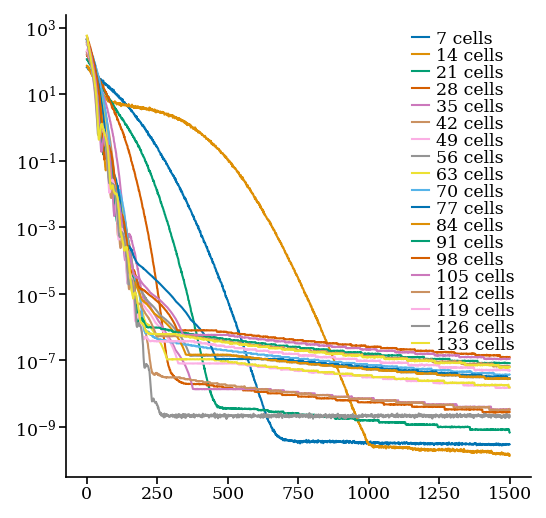

In [10]:
fig, ax = plt.subplots(figsize=(4,4))
[ax.semilogy(loss_history_) for loss_history_ in loss_history]
ax.legend([f'{7*i} cells' for i in range(1,len(loss_history)+1)])

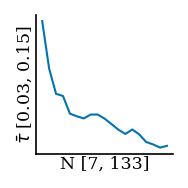

In [63]:
figsize = set_size(fraction=(1/4,1/4),mode='square')
fig, ax = plt.subplots(figsize=figsize)#,dpi=300)

x = np.arange(1,20)*7
ax.plot(x, trajectory_lengths)
#ymin, ymax = ax.get_ylim()
ax.set_xlabel(r'N [{}, {}]'.format(x[0],x[-1]),fontsize='small')
ax.set_xticks([])
ymin, ymax = np.around(np.min(trajectory_lengths),2), np.around(np.max(trajectory_lengths),2)
ax.set_ylabel(r'$\bar{\tau}$ ' + '[{}, {}]'.format(ymin,ymax),fontsize='small')
ax.set_yticks([])
#ax.set_ylim(0,model.unit_cell.radius/4)
#ax.set_xticks([x[0],x[-1]])
#ax.set_yticks([np.around(trajectory_lengths[0],2),np.around(trajectory_lengths[-1],2)])

fig.tight_layout(pad=0.5, h_pad=0, w_pad=0)
savefigs=True
if savefigs:
    fig.savefig('../results/learning-trajectory-lengths')